![header](../figures/logos_partenaires._cmems_se.jpg)


<div class="alert alert-block alert-success">
<h1><center>Compare SSH, gradients and Laplacian pdf in Gulf Stream</center></h1></div>

***
**Authors:**  Datlas, IGE, IMEDEA & CLS <br>
**Copyright:** 2022 Datlas, IGE, IMEDEA & CLS <br>
**License:** MIT

In [8]:
import os
import glob
import sys
sys.path.append('..')
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import scipy.signal as sig


from src import mod_plot
from src import mod_switchvar
from src import mod_spectral
from src.dict_regions_info import *

In [9]:

region_info = RegionInfo('GS_info').region_info   # Region dictionary info from dict_regions_info.py

label_noisy = 'Noisy'   # Name for plots title and saving figures
label_denoised = 'Denoised'   # Name for plots title and saving figures


name_noisy = 'ssha_karin_2_edited' # Name of the denoised SWOT variable in the xarray file 
name_denoised = 'duacs_ssha_karin_2_filtered' # Name of the denoised SWOT variable in the xarray file 

len_seg = 500 # in num_lines point (i.e. every 2km)

<div class="alert alert-info" role="alert">

<h2>A - 1 day orbit </h2>

</div>
 

In [3]:
path_data = '../swot_data/V1.0.2_CALVAL/SWOT_L3_LR_SSH_Expert_GS_v1.0.2.nc'

orbit = '1d'

ds_SWOT = xr.open_mfdataset(path_data)
  

In [4]:
ds_SWOT

<xarray.Dataset>
Dimensions:                        (num_lines: 12804, num_pixels: 69)
Coordinates:
    longitude                      (num_lines, num_pixels) float64 dask.array<chunksize=(12804, 69), meta=np.ndarray>
    latitude                       (num_lines, num_pixels) float64 dask.array<chunksize=(12804, 69), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/13)
    distance_to_coast              (num_lines, num_pixels) float64 dask.array<chunksize=(12804, 69), meta=np.ndarray>
    duacs_relative_vorticity       (num_lines, num_pixels) float64 dask.array<chunksize=(12804, 69), meta=np.ndarray>
    duacs_speed_zonal              (num_lines, num_pixels) float64 dask.array<chunksize=(12804, 69), meta=np.ndarray>
    duacs_speed_meridional         (num_lines, num_pixels) float64 dask.array<chunksize=(12804, 69), meta=np.ndarray>
    duacs_ssha_karin_2_filtered    (num_lines, num_pixels) float64 dask.array<chunksize=(12804, 69), meta=np.ndarray>
    time                           (num_lines, num_pixels) datetime64[ns] dask.array<chunksize=(12804, 69), meta=np.ndarray>
    ...                             ...
    swh_model                      (num_lines, num_pixels) float64 dask.array<chunksize=(12804, 69), meta=np.ndarray>
    duacs_editing_flag             (num_lines, num_pixels) float32 dask.array<chunksize=(12804, 69), meta=np.ndarray>
    ssha_karin_2_edited            (num_lines, num_pixels) float64 dask.array<chunksize=(12804, 69), meta=np.ndarray>
    residuals                      (num_lines, num_pixels) float64 dask.array<chunksize=(12804, 69), meta=np.ndarray>
    cycle_number                   (num_lines) float32 dask.array<chunksize=(12804,), meta=np.ndarray>
    pass_number                    (num_lines) float32 dask.array<chunksize=(12804,), meta=np.ndarray>

## Compute psd for SSH

In [14]:
%%time  
  
ssh_new_editing_segs = mod_spectral.retrieve_segments(ds_SWOT, name_noisy, len_seg)
  
ssh_denoised_unet_segs = mod_spectral.retrieve_segments(ds_SWOT, name_denoised, len_seg)
 

wavenum, psd_new_editing = sig.welch(np.ravel(ssh_new_editing_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_unet = sig.welch(np.ravel(ssh_denoised_unet_segs),0.5,nperseg=len_seg,noverlap=0) 

wavenum, psd_new_editing, psd_denoised_unet = wavenum[:-1], psd_new_editing[:-1], psd_denoised_unet[:-1] 


Number of segs 527 of size 500
Number of segs 527 of size 500
CPU times: user 18.9 s, sys: 353 ms, total: 19.3 s
Wall time: 23.8 s


## Plot psd for SSH

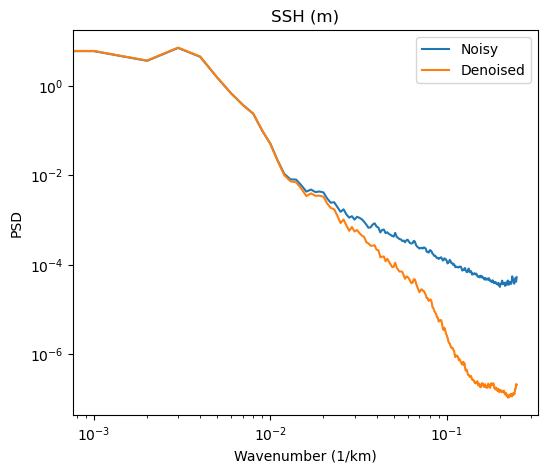

In [15]:
plt.figure(figsize=(6,5))
plt.title('SSH (m)')
plt.loglog(wavenum,psd_new_editing,label=label_noisy)
plt.loglog(wavenum,psd_denoised_unet,label=label_denoised) 
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('PSD')
plt.legend()
plt.savefig('../figures/psd_compare_v102_'+region_info['name']+'_'+orbit+'_ssh.png')

plt.show()



## Compute SSH gradients and Laplacian

In [12]:
grad_new_editing, lapl_new_editing = mod_switchvar.deriv1and2(ds_SWOT[name_noisy])
grad_denoised_unet, lapl_denoised_unet = mod_switchvar.deriv1and2(ds_SWOT[name_denoised]) 


ds_SWOT = ds_SWOT.assign(grad_new_editing=lambda ds_SWOT: ds_SWOT[name_noisy] * 0 + grad_new_editing)
ds_SWOT = ds_SWOT.assign(grad_denoised_unet=lambda ds_SWOT: ds_SWOT[name_denoised] * 0 + grad_denoised_unet) 

ds_SWOT = ds_SWOT.assign(lapl_new_editing=lambda ds_SWOT: ds_SWOT[name_noisy] * 0 + lapl_new_editing)
ds_SWOT = ds_SWOT.assign(lapl_denoised_unet=lambda ds_SWOT: ds_SWOT[name_denoised] * 0 + lapl_denoised_unet) 


## Compute psd for gradients

In [16]:
%%time  

name_var = 'grad_new_editing'
ssh_new_editing_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'grad_denoised_unet'
ssh_denoised_unet_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)  

wavenum, psd_new_editing = sig.welch(np.ravel(ssh_new_editing_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_unet = sig.welch(np.ravel(ssh_denoised_unet_segs),0.5,nperseg=len_seg,noverlap=0) 

wavenum, psd_new_editing, psd_denoised_unet = wavenum[:-1], psd_new_editing[:-1], psd_denoised_unet[:-1] 


Number of segs 527 of size 500
Number of segs 527 of size 500
Number of segs 527 of size 500
CPU times: user 31 s, sys: 624 ms, total: 31.7 s
Wall time: 39.3 s


## Plot psd for gradients

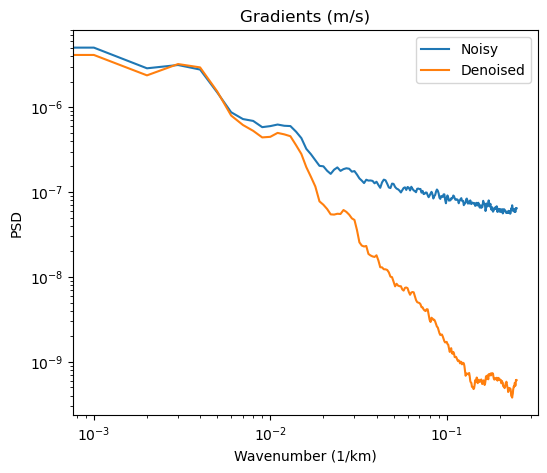

In [17]:
plt.figure(figsize=(6,5))
plt.title('Gradients (m/s)')
plt.loglog(wavenum,psd_new_editing,label=label_noisy)
plt.loglog(wavenum,psd_denoised_unet,label=label_denoised) 
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('PSD')
plt.legend()
plt.savefig('../figures/psd_compare_v102_'+region_info['name']+'_'+orbit+'_grad.png')

plt.show()



## Compute psd for Laplacians

In [18]:
%%time  

name_var = 'lapl_new_editing'
ssh_new_editing_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)

name_var = 'lapl_denoised_unet'
ssh_denoised_unet_segs = mod_spectral.retrieve_segments(ds_SWOT, name_var, len_seg)
 

wavenum, psd_new_editing = sig.welch(np.ravel(ssh_new_editing_segs),0.5,nperseg=len_seg,noverlap=0) 
wavenum, psd_denoised_unet = sig.welch(np.ravel(ssh_denoised_unet_segs),0.5,nperseg=len_seg,noverlap=0) 



wavenum, psd_new_editing, psd_denoised_unet = wavenum[:-1], psd_new_editing[:-1], psd_denoised_unet[:-1]

Number of segs 412 of size 500
Number of segs 412 of size 500
CPU times: user 16.3 s, sys: 329 ms, total: 16.7 s
Wall time: 18.8 s


## Plot psd for Laplacians

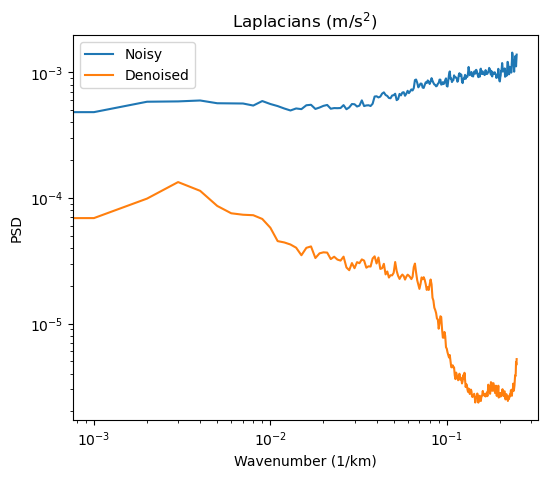

In [19]:
plt.figure(figsize=(6,5))
plt.title('Laplacians (m/s$^2$)')
plt.loglog(wavenum,psd_new_editing,label=label_noisy)
plt.loglog(wavenum,psd_denoised_unet,label=label_denoised) 
plt.xlabel('Wavenumber (1/km)')
plt.ylabel('PSD')
plt.legend()
plt.savefig('../figures/psd_compare_v102_'+region_info['name']+'_'+orbit+'_lapl.png')

plt.show()

